# Part 1: Cluster wallets based on how they interact with contracts

In [1]:
# 📊 Data Handling
import pandas as pd
import numpy as np

# 📈 Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# ⚙️ Preprocessing & Scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# 📈 Analysis
import scipy.stats as stats
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
  
# 🧠 Modeling
from sklearn.cluster import KMeans, DBSCAN
import hdbscan
from sklearn.metrics import silhouette_score

In [2]:
data = pd.read_csv('Transactions.csv')

# 1.1 Feature Engineering

In [42]:
df = data.copy()
df['BLOCK_TIMESTAMP'] = pd.to_datetime(df['BLOCK_TIMESTAMP'])
df = df.sort_values(by=['FROM_ADDRESS', 'BLOCK_TIMESTAMP'])
df.head()

,FROM_ADDRESS,TO_ADDRESS,VALUE,GAS,GAS_USED,BLOCK_TIMESTAMP,TX_HASH,FUNCTION_NAME,TYPE
66210,0x0000000000000068f116a894984e2db1123eb395,0x000056f7000000ece9003ca63978907a00ffd100,0.0,496693.0,10104.0,2024-09-25 00:17:11,0xce6ce49a75ff1df05cefb70ed12e6c8e645a07395c31...,authorizeOrder,CALL
41083,0x0000000000000068f116a894984e2db1123eb395,0x1e0049783f008a0085193e00003d00cd54003c71,0.0,94123.0,80185.0,2024-09-25 03:35:47,0xb4251303dd607d82c309529affe7b78cb132a04bad8d...,execute,CALL
2518,0x0000000000000068f116a894984e2db1123eb395,0x1e0049783f008a0085193e00003d00cd54003c71,0.0,132670.0,55713.0,2024-09-25 03:50:35,0xd265d449efb2b05801935d76a0ee5ab80127af50f941...,execute,CALL
11427,0x0000000000000068f116a894984e2db1123eb395,0x1e0049783f008a0085193e00003d00cd54003c71,0.0,101573.0,42176.0,2024-09-25 04:00:11,0xcf81214c433d453ce315039534d1d760ffb450bca06c...,execute,CALL
97931,0x0000000000000068f116a894984e2db1123eb395,0x1e0049783f008a0085193e00003d00cd54003c71,0.0,138015.0,49248.0,2024-09-25 04:07:11,0xfec1b2e6a7936bc0c14d06542ce1873d8491eca33ca7...,execute,CALL


In [43]:
#unique_function_count: Number of unique functions used
unique_function_count = df.groupby(['FROM_ADDRESS'])['FUNCTION_NAME'].nunique().rename('unique_function_count')

# total_tx_count: Total number of transactions
total_tx_count = df.groupby(['FROM_ADDRESS'])['TX_HASH'].nunique().rename('total_tx_count')

# avg_value_sent: Mean of VALUE
avg_value_sent = df.groupby(['FROM_ADDRESS'])['VALUE'].mean().rename('avg_value_sent')

# total_value_sent: Sum of VALUE
total_value_sent = df.groupby(['FROM_ADDRESS'])['VALUE'].sum().rename('total_value_sent')

# avg_gas_used: Mean of GAS_USED
avg_gas_used = df.groupby(['FROM_ADDRESS'])['GAS_USED'].mean().rename('avg_gas_used')

# gas_efficiency: GAS_USED / GAS averaged (how efficient they are)
avg_gas_used = df.groupby(['FROM_ADDRESS'])['GAS_USED'].mean()
avg_gas_provided = df.groupby(['FROM_ADDRESS'])['GAS'].mean()
gas_efficiency = (avg_gas_used / avg_gas_provided).rename('gas_efficiency')


# active_days: Number of days they were active 
active_days = df.groupby(['FROM_ADDRESS'])['BLOCK_TIMESTAMP'].nunique().rename('active_days')

# contract_diversity: Number of unique TO_ADDRESS used
contract_diversity = df.groupby(['FROM_ADDRESS'])['TO_ADDRESS'].nunique().rename('contract_diversity')

# avg_tx_per_day: total_tx_count / active_days
avg_tx_per_day = ((df.groupby(['FROM_ADDRESS'])['TX_HASH'].nunique()) / (df.groupby(['FROM_ADDRESS'])['BLOCK_TIMESTAMP'].nunique())).rename('avg_tx_per_day')

# first_last_tx_diff: Activity duration in days
first_last_tx_diff = ((df.groupby(['FROM_ADDRESS'])['BLOCK_TIMESTAMP'].max()) - (df.groupby(['FROM_ADDRESS'])['BLOCK_TIMESTAMP'].min())).rename('first_last_tx_diff')


# final data frame
df_features = pd.concat([
    unique_function_count,
    total_tx_count,
    avg_value_sent,
    total_value_sent,
    avg_gas_used,
    gas_efficiency,
    active_days,
    contract_diversity,
    avg_tx_per_day,
    first_last_tx_diff
], axis=1).reset_index()

In [44]:
float_cols = ['avg_value_sent', 'gas_efficiency', 'avg_tx_per_day']
df_features[float_cols] = df_features[float_cols].round(2)
df_features['first_last_tx_diff'] = df_features['first_last_tx_diff'].dt.days


In [45]:
df_features

,FROM_ADDRESS,unique_function_count,total_tx_count,avg_value_sent,total_value_sent,GAS_USED,gas_efficiency,active_days,contract_diversity,avg_tx_per_day,first_last_tx_diff
0,0x0000000000000068f116a894984e2db1123eb395,4,62,0.00,0.000000,27522.709677,0.12,60,5,1.03,14.0
1,0x0000000000001ff3684f28c67538d4d072c22734,3,30,0.03,0.987639,102411.000000,0.46,29,4,1.03,0.0
2,0x000000000000ad05ccc4f10045630fb830b95127,1,1,0.00,0.000000,17807.000000,0.15,1,1,1.00,0.0
3,0x000000000000c9b3e2c3ec88b1b4c0cd853f4321,3,3,0.00,0.000000,8218.000000,0.01,3,3,1.00,13.0
4,0x0000000000085d4780b73119b644ae5ecd22b376,2,2,0.00,0.000000,9028.000000,0.07,2,1,1.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...
15515,0xffee087852cb4898e6c3532e776e68bc68b1143b,1,2,0.00,0.000000,73820.000000,0.96,2,1,1.00,0.0
15516,0xfff1f7d097212ff54791121a06d5fa1e1aedfaf7,1,1,0.00,0.000000,51664.000000,0.76,1,1,1.00,0.0
15517,0xfff30c67eea809123596252e132d30e1eb75bc83,1,1,0.00,0.000000,3474.000000,0.00,1,1,1.00,0.0
15518,0xfff9691fce62fcebd90dfc2893e4f03b422514e8,1,1,0.00,0.000000,100479.000000,0.96,1,1,1.00,0.0


# 1.2 EDA

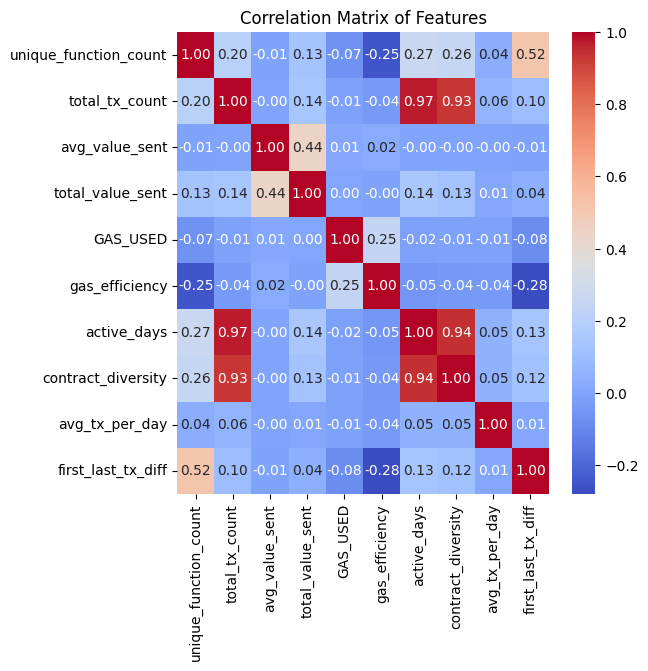

In [46]:
# Correlation Matrix 
plt.figure(figsize=(6, 6))
sns.heatmap(df_features.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Features")
plt.show()

## Based on the correlation matrix, we better to:
### keep contract_diversity and remove total_tx_count and active_days
### keep first_last_tx_diff and unique_function_count >> duration activity+complexity
### so-so avg_tx_per_day
### so-so gas_efficiency
### so-so avg_value_sent >> indenify whales
### remove total_value_sent
### remove GAS_USED

In [47]:
df_features.head()

,FROM_ADDRESS,unique_function_count,total_tx_count,avg_value_sent,total_value_sent,GAS_USED,gas_efficiency,active_days,contract_diversity,avg_tx_per_day,first_last_tx_diff
0,0x0000000000000068f116a894984e2db1123eb395,4,62,0.00,0.000000,27522.709677,0.12,60,5,1.03,14.0
1,0x0000000000001ff3684f28c67538d4d072c22734,3,30,0.03,0.987639,102411.000000,0.46,29,4,1.03,0.0
2,0x000000000000ad05ccc4f10045630fb830b95127,1,1,0.00,0.000000,17807.000000,0.15,1,1,1.00,0.0
3,0x000000000000c9b3e2c3ec88b1b4c0cd853f4321,3,3,0.00,0.000000,8218.000000,0.01,3,3,1.00,13.0
4,0x0000000000085d4780b73119b644ae5ecd22b376,2,2,0.00,0.000000,9028.000000,0.07,2,1,1.00,0.0


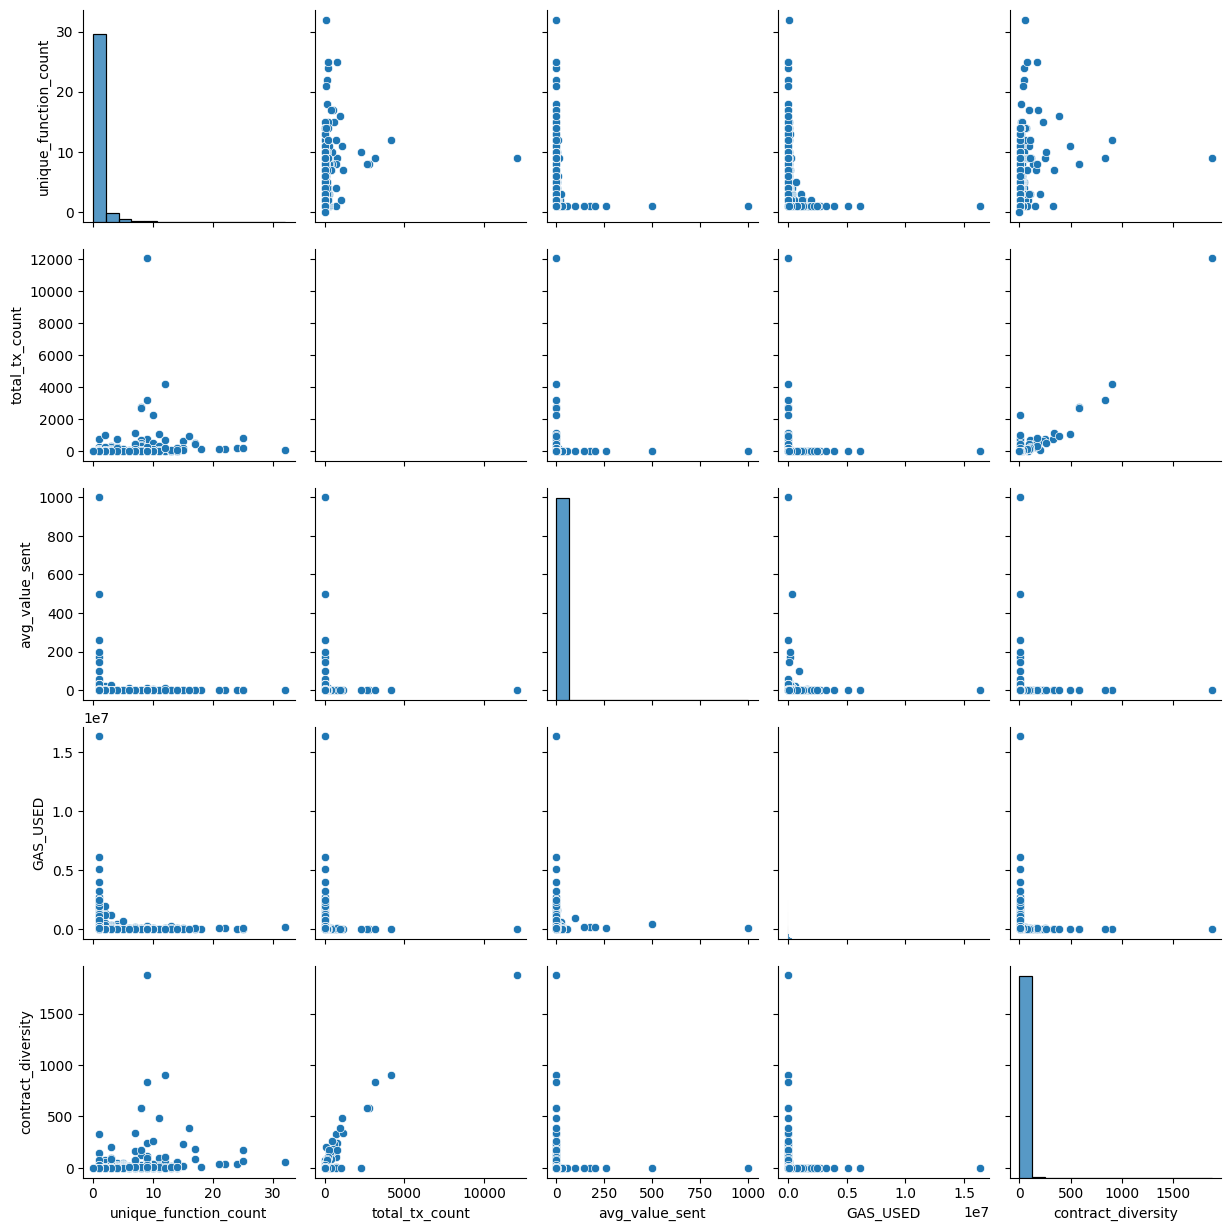

In [48]:
#Pairplot (Scatter Matrix) 
sns.pairplot(df_features[[
    'unique_function_count', 'total_tx_count', 'avg_value_sent',
    'GAS_USED', 'contract_diversity'
]])

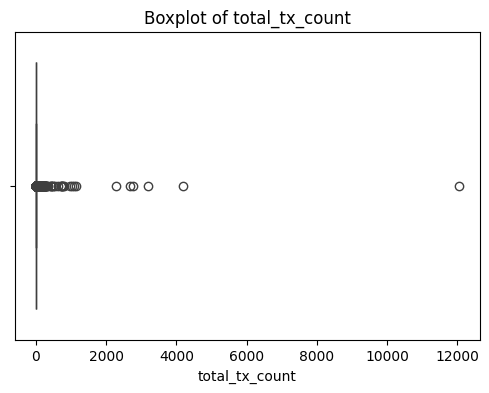

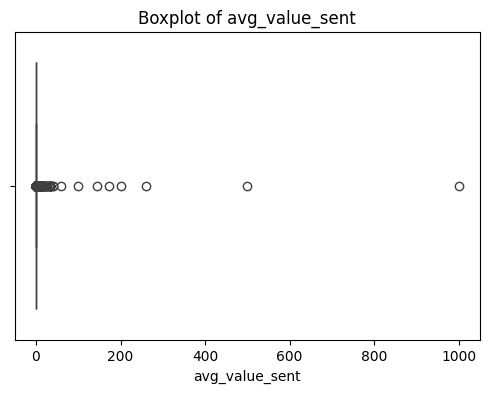

In [49]:
# Boxplots (Detect Outliers per Feature)
for feature in features_to_plot:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df_features[feature])
    plt.title(f'Boxplot of {feature}')
    plt.show()

In [50]:
df_features = df_features.fillna(0)
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15520 entries, 0 to 15519
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   FROM_ADDRESS           15520 non-null  object 
 1   unique_function_count  15520 non-null  int64  
 2   total_tx_count         15520 non-null  int64  
 3   avg_value_sent         15520 non-null  float64
 4   total_value_sent       15520 non-null  float64
 5   GAS_USED               15520 non-null  float64
 6   gas_efficiency         15520 non-null  float64
 7   active_days            15520 non-null  int64  
 8   contract_diversity     15520 non-null  int64  
 9   avg_tx_per_day         15520 non-null  float64
 10  first_last_tx_diff     15520 non-null  float64
dtypes: float64(6), int64(4), object(1)
memory usage: 1.3+ MB


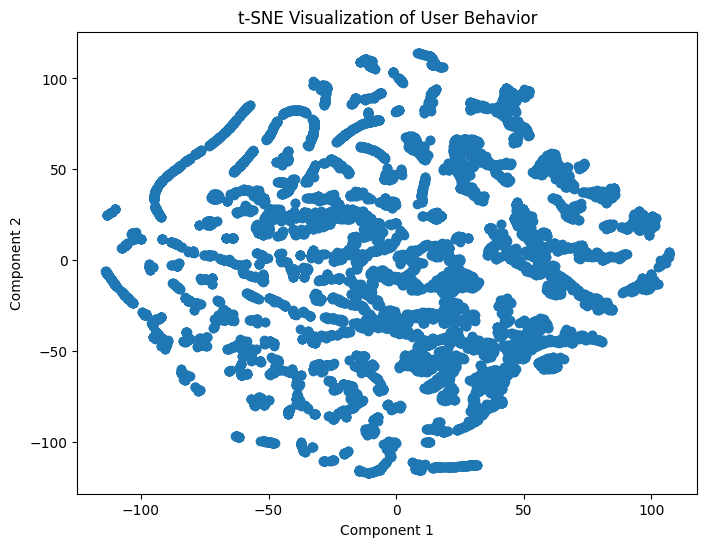

In [51]:
      
X = df_features.drop(columns=['FROM_ADDRESS']) 
X_scaled = StandardScaler().fit_transform(X)

tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])
plt.title("t-SNE Visualization of User Behavior")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

In [52]:
# Log Transformation for Skewed Features
df_transformed = df_features.copy()

cols_to_log = ['total_tx_count', 'avg_value_sent', 'GAS_USED', 'contract_diversity']

for col in cols_to_log:
    df_transformed[col] = np.log1p(df_transformed[col]) 

In [53]:
df_transformed

,FROM_ADDRESS,unique_function_count,total_tx_count,avg_value_sent,total_value_sent,GAS_USED,gas_efficiency,active_days,contract_diversity,avg_tx_per_day,first_last_tx_diff
0,0x0000000000000068f116a894984e2db1123eb395,4,4.143135,0.000000,0.000000,10.222803,0.12,60,1.791759,1.03,14.0
1,0x0000000000001ff3684f28c67538d4d072c22734,3,3.433987,0.029559,0.987639,11.536759,0.46,29,1.609438,1.03,0.0
2,0x000000000000ad05ccc4f10045630fb830b95127,1,0.693147,0.000000,0.000000,9.787403,0.15,1,0.693147,1.00,0.0
3,0x000000000000c9b3e2c3ec88b1b4c0cd853f4321,3,1.386294,0.000000,0.000000,9.014204,0.01,3,1.386294,1.00,13.0
4,0x0000000000085d4780b73119b644ae5ecd22b376,2,1.098612,0.000000,0.000000,9.108197,0.07,2,0.693147,1.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...
15515,0xffee087852cb4898e6c3532e776e68bc68b1143b,1,1.098612,0.000000,0.000000,11.209399,0.96,2,0.693147,1.00,0.0
15516,0xfff1f7d097212ff54791121a06d5fa1e1aedfaf7,1,0.693147,0.000000,0.000000,10.852536,0.76,1,0.693147,1.00,0.0
15517,0xfff30c67eea809123596252e132d30e1eb75bc83,1,0.693147,0.000000,0.000000,8.153350,0.00,1,0.693147,1.00,0.0
15518,0xfff9691fce62fcebd90dfc2893e4f03b422514e8,1,0.693147,0.000000,0.000000,11.517714,0.96,1,0.693147,1.00,0.0


In [54]:
# Feature Scaling
X = df_transformed.drop(columns=['FROM_ADDRESS'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [55]:
X_scaled

array([[ 2.11972409,  4.44037493, -0.15794123, ...,  2.57703406,
         0.11798292,  2.59163937],
       [ 1.30766549,  3.43982684, -0.03895616, ...,  2.09571743,
         0.11798292, -0.39296567],
       [-0.3164517 , -0.42727018, -0.15794123, ..., -0.32322838,
        -0.04334703, -0.39296567],
       ...,
       [-0.3164517 , -0.42727018, -0.15794123, ..., -0.32322838,
        -0.04334703, -0.39296567],
       [-0.3164517 , -0.42727018, -0.15794123, ..., -0.32322838,
        -0.04334703, -0.39296567],
       [-1.1285103 , -1.40524313, -0.15794123, ..., -2.15309024,
        -5.42101181, -0.39296567]])

/Users/bahareh/opt/anaconda3/lib/python3.9/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


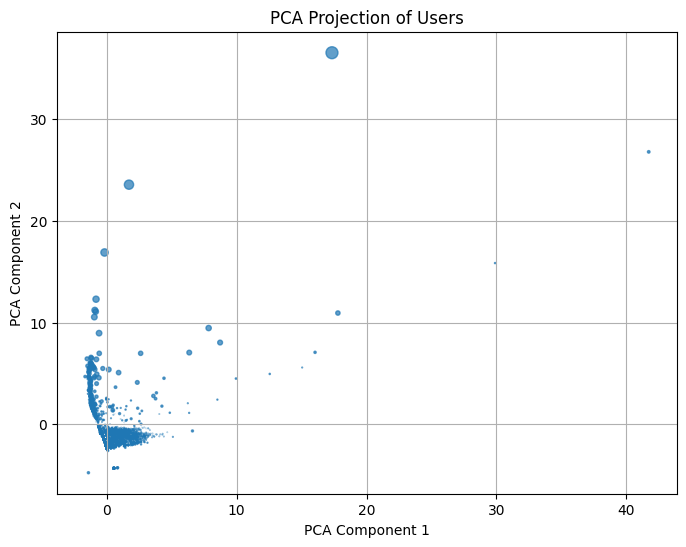

In [67]:
# Apply PCA 
pca = PCA(n_components=7)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],  alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Projection of Users")
plt.grid(True)
plt.show()

# DBSCAN Clustering

In [104]:
from sklearn.cluster import DBSCAN

# Use PCA output for clustering (optional: use X_scaled directly for better accuracy)
dbscan = DBSCAN(eps=0.5, min_samples=5)
cluster_labels = dbscan.fit_predict(X_pca)

# Add cluster labels to your dataframe
df_transformed['cluster_DBSCAN'] = cluster_labels

In [105]:
df_transformed

,FROM_ADDRESS,unique_function_count,total_tx_count,avg_value_sent,total_value_sent,GAS_USED,gas_efficiency,active_days,contract_diversity,avg_tx_per_day,first_last_tx_diff,cluster,cluster_HDBSCAN,cluster_kmeans,cluster_DBSCAN
0,0x0000000000000068f116a894984e2db1123eb395,4,4.143135,0.000000,0.000000,10.222803,0.12,60,1.791759,1.03,14.0,1,1,1,1
1,0x0000000000001ff3684f28c67538d4d072c22734,3,3.433987,0.029559,0.987639,11.536759,0.46,29,1.609438,1.03,0.0,-1,-1,0,-1
2,0x000000000000ad05ccc4f10045630fb830b95127,1,0.693147,0.000000,0.000000,9.787403,0.15,1,0.693147,1.00,0.0,0,0,0,0
3,0x000000000000c9b3e2c3ec88b1b4c0cd853f4321,3,1.386294,0.000000,0.000000,9.014204,0.01,3,1.386294,1.00,13.0,1,1,1,1
4,0x0000000000085d4780b73119b644ae5ecd22b376,2,1.098612,0.000000,0.000000,9.108197,0.07,2,0.693147,1.00,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15515,0xffee087852cb4898e6c3532e776e68bc68b1143b,1,1.098612,0.000000,0.000000,11.209399,0.96,2,0.693147,1.00,0.0,0,0,5,0
15516,0xfff1f7d097212ff54791121a06d5fa1e1aedfaf7,1,0.693147,0.000000,0.000000,10.852536,0.76,1,0.693147,1.00,0.0,0,0,5,0
15517,0xfff30c67eea809123596252e132d30e1eb75bc83,1,0.693147,0.000000,0.000000,8.153350,0.00,1,0.693147,1.00,0.0,0,0,0,0
15518,0xfff9691fce62fcebd90dfc2893e4f03b422514e8,1,0.693147,0.000000,0.000000,11.517714,0.96,1,0.693147,1.00,0.0,0,0,5,0


In [106]:
df_transformed['cluster_DBSCAN'].value_counts()

 0     13183
 1      1756
-1       490
 3        11
 2        10
 6        10
 4         9
 5         8
 12        7
 9         7
 8         6
 13        5
 7         5
 10        5
 14        5
 11        3
Name: cluster_DBSCAN, dtype: int64

In [107]:
cluster_summary = df_transformed.groupby('cluster_DBSCAN').mean()
cluster_summary

/var/folders/nw/7766myvd65gfypd6nd1lgsb40000gn/T/ipykernel_15944/1215762919.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_summary = df_transformed.groupby('cluster_DBSCAN').mean()


,unique_function_count,total_tx_count,avg_value_sent,total_value_sent,GAS_USED,gas_efficiency,active_days,contract_diversity,avg_tx_per_day,first_last_tx_diff,cluster,cluster_HDBSCAN,cluster_kmeans
cluster_DBSCAN,,,,,,,,,,,,,
-1,4.620408,2.916222,0.389426,18.511160,10.157116,0.207837,93.636735,1.855815,1.190204,8.491837,-1.0,-1.0,2.065306
0,1.117196,0.802347,0.026768,0.041682,10.246057,0.432247,1.533263,0.730110,1.000925,0.000000,0.0,0.0,3.040052
1,2.459567,1.868940,0.001744,0.015418,9.470862,0.143195,8.168565,1.144807,1.001486,13.739180,1.0,1.0,1.026765
2,1.000000,0.693147,2.377560,9.845600,11.231092,0.827000,1.000000,0.693147,1.000000,0.000000,2.0,2.0,5.000000
3,1.000000,0.693147,3.490824,31.818182,10.694333,0.604545,1.000000,0.693147,1.000000,0.000000,3.0,3.0,5.000000
4,1.000000,1.098612,0.000000,0.000000,6.214591,0.000000,1.000000,0.693147,2.000000,0.000000,4.0,4.0,1.000000
5,9.625000,2.597628,0.000000,0.009192,9.889254,0.033750,12.500000,2.340935,1.000000,13.875000,5.0,5.0,1.000000
6,1.000000,0.774240,0.000000,0.000000,0.000000,0.000000,1.200000,0.693147,1.000000,0.000000,6.0,6.0,3.000000
7,5.200000,2.076812,0.000000,0.000000,10.000340,0.050000,7.200000,1.816955,1.000000,0.000000,7.0,7.0,3.000000


In [108]:
df_transformed.head(1)

,FROM_ADDRESS,unique_function_count,total_tx_count,avg_value_sent,total_value_sent,GAS_USED,gas_efficiency,active_days,contract_diversity,avg_tx_per_day,first_last_tx_diff,cluster,cluster_HDBSCAN,cluster_kmeans,cluster_DBSCAN
0,0x0000000000000068f116a894984e2db1123eb395,4,4.143135,0.0,0.0,10.222803,0.12,60,1.791759,1.03,14.0,1,1,1,1


In [109]:
cluster_mapping_DBSCAN = {
    3: "whale_wallets",
    5: "defi_farmers",
    11: "defi_farmers",
    9: "long_term_passive",
    10: "long_term_passive",
    0: "inactive_wallet",
    1: "inactive_wallet",
    2: "nft_or_airdrop_only",
    4: "nft_or_airdrop_only",
    6: "nft_or_airdrop_only",
    8: "nft_or_airdrop_only",
    14: "nft_or_airdrop_only",
    7: "bot_or_bet_like",
    13: "bot_or_bet_like",
    -1: "noise_or_misc"
}


df_transformed['DBSCAN_cluster'] = df_transformed['cluster_DBSCAN'].map(cluster_mapping_DBSCAN)

df_transformed

,FROM_ADDRESS,unique_function_count,total_tx_count,avg_value_sent,total_value_sent,GAS_USED,gas_efficiency,active_days,contract_diversity,avg_tx_per_day,first_last_tx_diff,cluster,cluster_HDBSCAN,cluster_kmeans,cluster_DBSCAN,DBSCAN_cluster
0,0x0000000000000068f116a894984e2db1123eb395,4,4.143135,0.000000,0.000000,10.222803,0.12,60,1.791759,1.03,14.0,1,1,1,1,inactive_wallet
1,0x0000000000001ff3684f28c67538d4d072c22734,3,3.433987,0.029559,0.987639,11.536759,0.46,29,1.609438,1.03,0.0,-1,-1,0,-1,noise_or_misc
2,0x000000000000ad05ccc4f10045630fb830b95127,1,0.693147,0.000000,0.000000,9.787403,0.15,1,0.693147,1.00,0.0,0,0,0,0,inactive_wallet
3,0x000000000000c9b3e2c3ec88b1b4c0cd853f4321,3,1.386294,0.000000,0.000000,9.014204,0.01,3,1.386294,1.00,13.0,1,1,1,1,inactive_wallet
4,0x0000000000085d4780b73119b644ae5ecd22b376,2,1.098612,0.000000,0.000000,9.108197,0.07,2,0.693147,1.00,0.0,0,0,0,0,inactive_wallet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15515,0xffee087852cb4898e6c3532e776e68bc68b1143b,1,1.098612,0.000000,0.000000,11.209399,0.96,2,0.693147,1.00,0.0,0,0,5,0,inactive_wallet
15516,0xfff1f7d097212ff54791121a06d5fa1e1aedfaf7,1,0.693147,0.000000,0.000000,10.852536,0.76,1,0.693147,1.00,0.0,0,0,5,0,inactive_wallet
15517,0xfff30c67eea809123596252e132d30e1eb75bc83,1,0.693147,0.000000,0.000000,8.153350,0.00,1,0.693147,1.00,0.0,0,0,0,0,inactive_wallet
15518,0xfff9691fce62fcebd90dfc2893e4f03b422514e8,1,0.693147,0.000000,0.000000,11.517714,0.96,1,0.693147,1.00,0.0,0,0,5,0,inactive_wallet


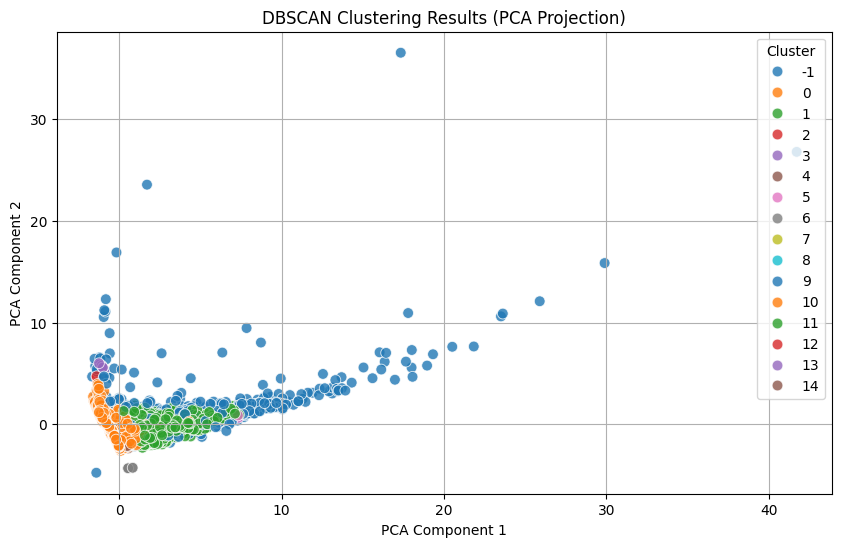

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1],
    hue=cluster_labels,
    palette="tab10",
    s=60,
    alpha=0.8,
    legend='full'
)
plt.title("DBSCAN Clustering Results (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# HDBSCAN Clustering

In [79]:
import hdbscan

In [85]:
# Run HDBSCAN on scaled features (or PCA-transformed)
clusterer_HDBSCAN = hdbscan.HDBSCAN(
    min_cluster_size=10,        # Minimum cluster size
    min_samples=10,             # Core point threshold (optional)
    prediction_data=True       # Enables soft clustering
)

clusterer_HDBSCAN_labels = clusterer_HDBSCAN.fit_predict(X_scaled)

# Add to dataframe
df_transformed['cluster_HDBSCAN'] = cluster_labels

/Users/bahareh/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/bahareh/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


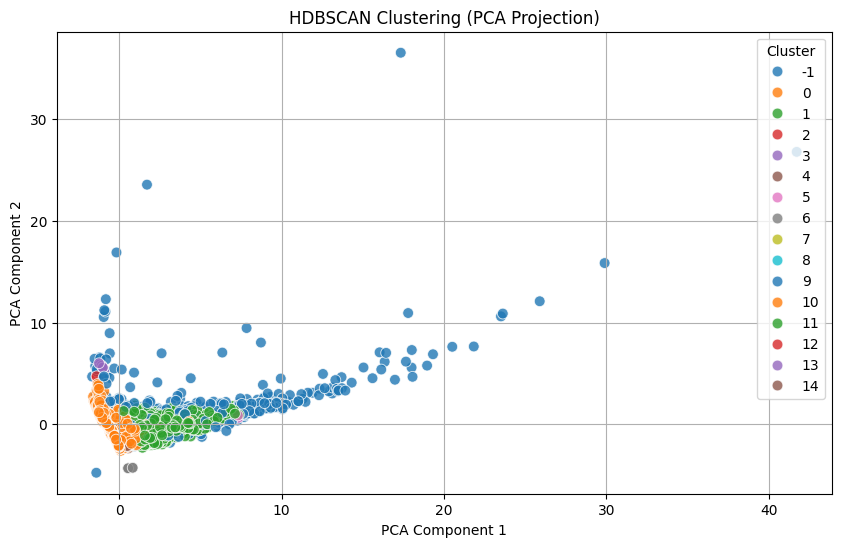

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1],
    hue=cluster_labels,
    palette='tab10',
    alpha=0.8,
    s=60,
    legend='full'
)
plt.title("HDBSCAN Clustering (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

In [87]:
df_transformed.groupby('cluster_HDBSCAN').mean(numeric_only=True)

,unique_function_count,total_tx_count,avg_value_sent,total_value_sent,GAS_USED,gas_efficiency,active_days,contract_diversity,avg_tx_per_day,first_last_tx_diff,cluster
cluster_HDBSCAN,,,,,,,,,,,
-1,4.620408,2.916222,0.389426,18.511160,10.157116,0.207837,93.636735,1.855815,1.190204,8.491837,-1.0
0,1.117196,0.802347,0.026768,0.041682,10.246057,0.432247,1.533263,0.730110,1.000925,0.000000,0.0
1,2.459567,1.868940,0.001744,0.015418,9.470862,0.143195,8.168565,1.144807,1.001486,13.739180,1.0
2,1.000000,0.693147,2.377560,9.845600,11.231092,0.827000,1.000000,0.693147,1.000000,0.000000,2.0
3,1.000000,0.693147,3.490824,31.818182,10.694333,0.604545,1.000000,0.693147,1.000000,0.000000,3.0
4,1.000000,1.098612,0.000000,0.000000,6.214591,0.000000,1.000000,0.693147,2.000000,0.000000,4.0
5,9.625000,2.597628,0.000000,0.009192,9.889254,0.033750,12.500000,2.340935,1.000000,13.875000,5.0
6,1.000000,0.774240,0.000000,0.000000,0.000000,0.000000,1.200000,0.693147,1.000000,0.000000,6.0
7,5.200000,2.076812,0.000000,0.000000,10.000340,0.050000,7.200000,1.816955,1.000000,0.000000,7.0


In [110]:
cluster_label_map = {
    3: 'whale_wallet',
    5: 'defi_farmer',
    11: 'defi_farmer',
    0: 'inactive_wallet',
    2: 'inactive_wallet',
    4: 'inactive_wallet',
    6: 'inactive_wallet',
    14: 'inactive_wallet',
    7: 'bot_like_user',
    12: 'airdrop_hunter',
    13: 'airdrop_hunter',
    1: 'long_term_passive',
    9: 'long_term_passive',
    10: 'long_term_passive',
    -1: 'noise'
}


df_transformed['HDBSCAN_cluster'] = df_transformed['cluster_HDBSCAN'].map(cluster_label_map)

In [111]:
df_transformed

,FROM_ADDRESS,unique_function_count,total_tx_count,avg_value_sent,total_value_sent,GAS_USED,gas_efficiency,active_days,contract_diversity,avg_tx_per_day,first_last_tx_diff,cluster,cluster_HDBSCAN,cluster_kmeans,cluster_DBSCAN,DBSCAN_cluster,HDBSCAN_cluster
0,0x0000000000000068f116a894984e2db1123eb395,4,4.143135,0.000000,0.000000,10.222803,0.12,60,1.791759,1.03,14.0,1,1,1,1,inactive_wallet,long_term_passive
1,0x0000000000001ff3684f28c67538d4d072c22734,3,3.433987,0.029559,0.987639,11.536759,0.46,29,1.609438,1.03,0.0,-1,-1,0,-1,noise_or_misc,noise
2,0x000000000000ad05ccc4f10045630fb830b95127,1,0.693147,0.000000,0.000000,9.787403,0.15,1,0.693147,1.00,0.0,0,0,0,0,inactive_wallet,inactive_wallet
3,0x000000000000c9b3e2c3ec88b1b4c0cd853f4321,3,1.386294,0.000000,0.000000,9.014204,0.01,3,1.386294,1.00,13.0,1,1,1,1,inactive_wallet,long_term_passive
4,0x0000000000085d4780b73119b644ae5ecd22b376,2,1.098612,0.000000,0.000000,9.108197,0.07,2,0.693147,1.00,0.0,0,0,0,0,inactive_wallet,inactive_wallet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15515,0xffee087852cb4898e6c3532e776e68bc68b1143b,1,1.098612,0.000000,0.000000,11.209399,0.96,2,0.693147,1.00,0.0,0,0,5,0,inactive_wallet,inactive_wallet
15516,0xfff1f7d097212ff54791121a06d5fa1e1aedfaf7,1,0.693147,0.000000,0.000000,10.852536,0.76,1,0.693147,1.00,0.0,0,0,5,0,inactive_wallet,inactive_wallet
15517,0xfff30c67eea809123596252e132d30e1eb75bc83,1,0.693147,0.000000,0.000000,8.153350,0.00,1,0.693147,1.00,0.0,0,0,0,0,inactive_wallet,inactive_wallet
15518,0xfff9691fce62fcebd90dfc2893e4f03b422514e8,1,0.693147,0.000000,0.000000,11.517714,0.96,1,0.693147,1.00,0.0,0,0,5,0,inactive_wallet,inactive_wallet


# K-means Clustering

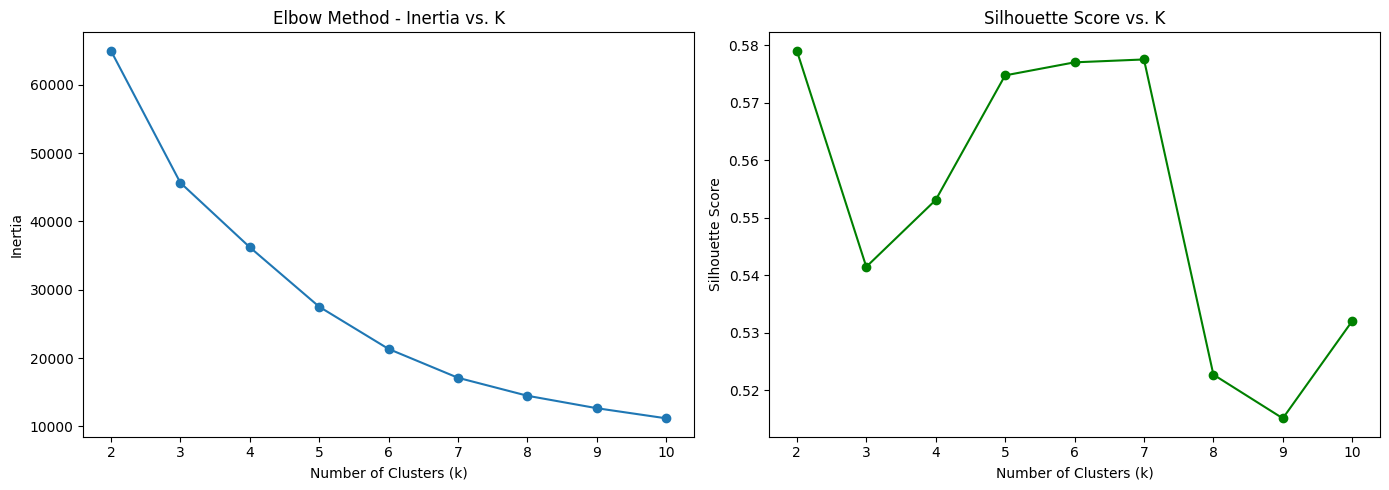

In [66]:
#  Elbow & Silhouette
inertia = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) 
    labels = kmeans.fit_predict(X_pca)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_pca, labels))

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].plot(k_range, inertia, marker='o')
ax[0].set_title('Elbow Method - Inertia vs. K')
ax[0].set_xlabel('Number of Clusters (k)')
ax[0].set_ylabel('Inertia')

ax[1].plot(k_range, silhouette_scores, marker='o', color='green')
ax[1].set_title('Silhouette Score vs. K')
ax[1].set_xlabel('Number of Clusters (k)')
ax[1].set_ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

In [88]:
X = df_transformed.drop(columns=['FROM_ADDRESS'], axis=1) 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K=7
kmeans = KMeans(n_clusters=7, random_state=42, n_init='auto')
df_transformed['cluster_kmeans'] = kmeans.fit_predict(X_scaled)

In [89]:
df_transformed['cluster_kmeans'].value_counts()

5    8129
0    5276
1    1781
2     274
3      53
6       6
4       1
Name: cluster_kmeans, dtype: int64

In [112]:
df_transformed.groupby('cluster_kmeans').mean(numeric_only=True)

,unique_function_count,total_tx_count,avg_value_sent,total_value_sent,GAS_USED,gas_efficiency,active_days,contract_diversity,avg_tx_per_day,first_last_tx_diff,cluster,cluster_HDBSCAN,cluster_DBSCAN
cluster_kmeans,,,,,,,,,,,,,
0,1.292077,0.960363,0.002763,0.014809,8.569090,0.049862,2.463419,0.780418,1.011393,0.026156,-0.020849,-0.020849,-0.020849
1,2.352049,1.867848,0.004021,0.071241,9.446108,0.143936,8.407075,1.125035,1.011044,13.651319,0.972487,0.972487,0.972487
2,7.357664,3.797542,0.083192,17.405275,10.141577,0.134599,95.886861,2.608291,1.029015,12.916058,-0.656934,-0.656934,-0.656934
3,2.830189,2.343666,0.000188,0.008454,7.157882,0.041887,25.981132,1.390410,1.152830,3.962264,9.584906,9.584906,9.584906
4,2.000000,3.135494,0.000000,0.000000,10.618261,0.180000,1.000000,0.693147,22.000000,0.000000,-1.000000,-1.000000,-1.000000
5,1.025710,0.719259,0.069416,0.550565,11.337813,0.677807,1.073072,0.702762,1.000715,0.039857,-0.004921,-0.004921,-0.004921
6,9.333333,8.224102,0.021365,107.661018,9.674976,0.070000,2933.666667,5.816519,1.410000,14.000000,-1.000000,-1.000000,-1.000000


In [115]:
df_transformed

,FROM_ADDRESS,unique_function_count,total_tx_count,avg_value_sent,total_value_sent,GAS_USED,gas_efficiency,active_days,contract_diversity,avg_tx_per_day,first_last_tx_diff,cluster,cluster_HDBSCAN,cluster_kmeans,cluster_DBSCAN,DBSCAN_cluster,HDBSCAN_cluster,Kmeans_cluster
0,0x0000000000000068f116a894984e2db1123eb395,4,4.143135,0.000000,0.000000,10.222803,0.12,60,1.791759,1.03,14.0,1,1,1,1,inactive_wallet,long_term_passive,airdrop_hunter
1,0x0000000000001ff3684f28c67538d4d072c22734,3,3.433987,0.029559,0.987639,11.536759,0.46,29,1.609438,1.03,0.0,-1,-1,0,-1,noise_or_misc,noise,inactive_wallet
2,0x000000000000ad05ccc4f10045630fb830b95127,1,0.693147,0.000000,0.000000,9.787403,0.15,1,0.693147,1.00,0.0,0,0,0,0,inactive_wallet,inactive_wallet,inactive_wallet
3,0x000000000000c9b3e2c3ec88b1b4c0cd853f4321,3,1.386294,0.000000,0.000000,9.014204,0.01,3,1.386294,1.00,13.0,1,1,1,1,inactive_wallet,long_term_passive,airdrop_hunter
4,0x0000000000085d4780b73119b644ae5ecd22b376,2,1.098612,0.000000,0.000000,9.108197,0.07,2,0.693147,1.00,0.0,0,0,0,0,inactive_wallet,inactive_wallet,inactive_wallet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15515,0xffee087852cb4898e6c3532e776e68bc68b1143b,1,1.098612,0.000000,0.000000,11.209399,0.96,2,0.693147,1.00,0.0,0,0,5,0,inactive_wallet,inactive_wallet,mini_whale
15516,0xfff1f7d097212ff54791121a06d5fa1e1aedfaf7,1,0.693147,0.000000,0.000000,10.852536,0.76,1,0.693147,1.00,0.0,0,0,5,0,inactive_wallet,inactive_wallet,mini_whale
15517,0xfff30c67eea809123596252e132d30e1eb75bc83,1,0.693147,0.000000,0.000000,8.153350,0.00,1,0.693147,1.00,0.0,0,0,0,0,inactive_wallet,inactive_wallet,inactive_wallet
15518,0xfff9691fce62fcebd90dfc2893e4f03b422514e8,1,0.693147,0.000000,0.000000,11.517714,0.96,1,0.693147,1.00,0.0,0,0,5,0,inactive_wallet,inactive_wallet,mini_whale


In [114]:
kmeans_cluster_map = {
    0: 'inactive_wallet',
    1: 'airdrop_hunter',
    2: 'defi_farmer',
    3: 'long_term_passive',
    4: 'bot_like_user',
    5: 'mini_whale',
    6: 'whale_wallet'
}

df_transformed['Kmeans_cluster'] = df_transformed['cluster_kmeans'].map(kmeans_cluster_map)

# Digram 

In [95]:
median_days = df_features['active_days'].median()
df_features['active_days_high'] = (df_features['active_days'] > median_days).astype(int)

median_function = df_features['unique_function_count'].median()
df_features['function_high'] = (df_features['unique_function_count'] > median_function).astype(int)

median_tx = df_features['total_tx_count'].median()
df_features['tx_high'] = (df_features['total_tx_count'] > median_tx).astype(int)

In [96]:
df_features

,FROM_ADDRESS,unique_function_count,total_tx_count,avg_value_sent,total_value_sent,GAS_USED,gas_efficiency,active_days,contract_diversity,avg_tx_per_day,first_last_tx_diff,pca1,pca2,active_days_high,function_high,tx_high
0,0x0000000000000068f116a894984e2db1123eb395,4,62,0.00,0.000000,27522.709677,0.12,60,5,1.03,14.0,5.795830,0.771388,1,1,1
1,0x0000000000001ff3684f28c67538d4d072c22734,3,30,0.03,0.987639,102411.000000,0.46,29,4,1.03,0.0,3.016240,1.426764,1,1,1
2,0x000000000000ad05ccc4f10045630fb830b95127,1,1,0.00,0.000000,17807.000000,0.15,1,1,1.00,0.0,-0.457094,-0.716559,0,0,0
3,0x000000000000c9b3e2c3ec88b1b4c0cd853f4321,3,3,0.00,0.000000,8218.000000,0.01,3,3,1.00,13.0,2.916394,-0.589179,1,1,1
4,0x0000000000085d4780b73119b644ae5ecd22b376,2,2,0.00,0.000000,9028.000000,0.07,2,1,1.00,0.0,0.315729,-0.916246,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15515,0xffee087852cb4898e6c3532e776e68bc68b1143b,1,2,0.00,0.000000,73820.000000,0.96,2,1,1.00,0.0,-0.937499,1.113561,1,0,1
15516,0xfff1f7d097212ff54791121a06d5fa1e1aedfaf7,1,1,0.00,0.000000,51664.000000,0.76,1,1,1.00,0.0,-1.031389,0.623509,0,0,0
15517,0xfff30c67eea809123596252e132d30e1eb75bc83,1,1,0.00,0.000000,3474.000000,0.00,1,1,1.00,0.0,-0.191105,-1.520772,0,0,0
15518,0xfff9691fce62fcebd90dfc2893e4f03b422514e8,1,1,0.00,0.000000,100479.000000,0.96,1,1,1.00,0.0,-1.248412,1.172179,0,0,0


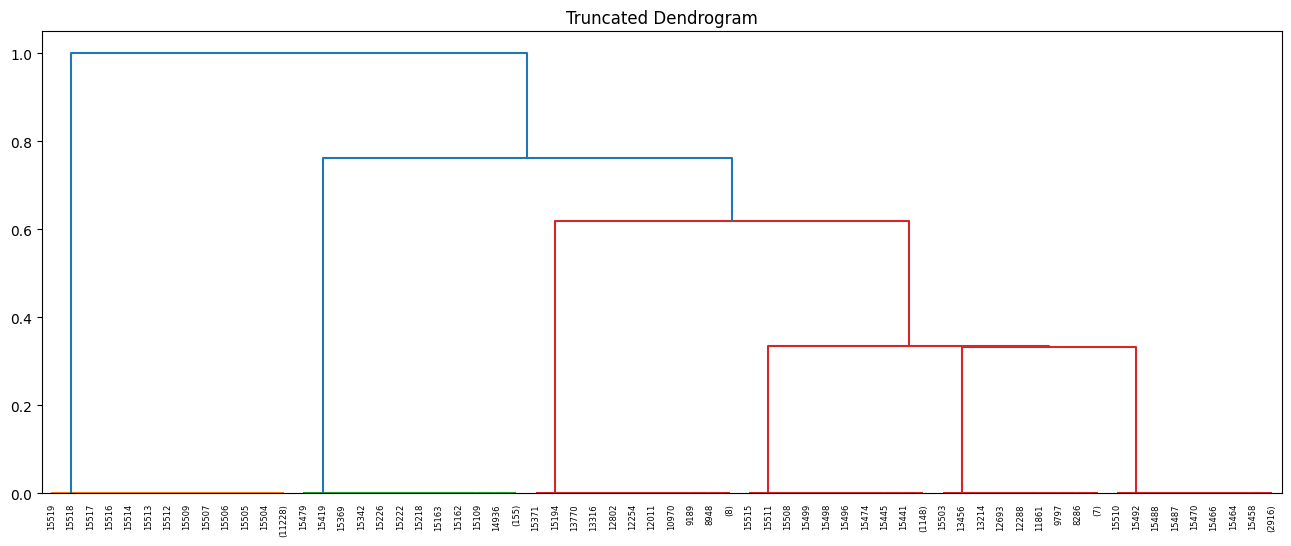

In [100]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt


binary_features = ['active_days_high', 'function_high', 'tx_high']  
X_bin = df_features[binary_features]
X_bin = X_bin.fillna(0).astype(int)
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

jaccard_dist = pdist(X_bin, metric='jaccard')

linkage_matrix = linkage(jaccard_dist, method='average')  # average یا complete بهتره برای داده باینری

plt.figure(figsize=(16, 6))
dendrogram(
    linkage_matrix,
    truncate_mode='level',  # فقط n سطح اول
    p=12,                     # تعداد سطوح (مثلاً 5)
    leaf_rotation=90,
    leaf_font_size=6
)
plt.title("Truncated Dendrogram")
plt.show()

In [101]:
from scipy.cluster.hierarchy import fcluster
clusters = fcluster(linkage_matrix, t=5, criterion='maxclust')  # مثلاً ۵ خوشه
df_features['cluster_hierarchical'] = clusters

In [102]:
df_features

,FROM_ADDRESS,unique_function_count,total_tx_count,avg_value_sent,total_value_sent,GAS_USED,gas_efficiency,active_days,contract_diversity,avg_tx_per_day,first_last_tx_diff,pca1,pca2,active_days_high,function_high,tx_high,cluster_hierarchical
0,0x0000000000000068f116a894984e2db1123eb395,4,62,0.00,0.000000,27522.709677,0.12,60,5,1.03,14.0,5.795830,0.771388,1,1,1,5
1,0x0000000000001ff3684f28c67538d4d072c22734,3,30,0.03,0.987639,102411.000000,0.46,29,4,1.03,0.0,3.016240,1.426764,1,1,1,5
2,0x000000000000ad05ccc4f10045630fb830b95127,1,1,0.00,0.000000,17807.000000,0.15,1,1,1.00,0.0,-0.457094,-0.716559,0,0,0,1
3,0x000000000000c9b3e2c3ec88b1b4c0cd853f4321,3,3,0.00,0.000000,8218.000000,0.01,3,3,1.00,13.0,2.916394,-0.589179,1,1,1,5
4,0x0000000000085d4780b73119b644ae5ecd22b376,2,2,0.00,0.000000,9028.000000,0.07,2,1,1.00,0.0,0.315729,-0.916246,1,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15515,0xffee087852cb4898e6c3532e776e68bc68b1143b,1,2,0.00,0.000000,73820.000000,0.96,2,1,1.00,0.0,-0.937499,1.113561,1,0,1,4
15516,0xfff1f7d097212ff54791121a06d5fa1e1aedfaf7,1,1,0.00,0.000000,51664.000000,0.76,1,1,1.00,0.0,-1.031389,0.623509,0,0,0,1
15517,0xfff30c67eea809123596252e132d30e1eb75bc83,1,1,0.00,0.000000,3474.000000,0.00,1,1,1.00,0.0,-0.191105,-1.520772,0,0,0,1
15518,0xfff9691fce62fcebd90dfc2893e4f03b422514e8,1,1,0.00,0.000000,100479.000000,0.96,1,1,1.00,0.0,-1.248412,1.172179,0,0,0,1


# Final Segmentation

In [118]:
# Create a new column showing number of methods that agree
df_transformed['segment_agreement_count'] = (
    (df_transformed['DBSCAN_cluster'] == df_transformed['HDBSCAN_cluster']).astype(int) +
    (df_transformed['HDBSCAN_cluster'] == df_transformed['Kmeans_cluster']).astype(int) +
    (df_transformed['Kmeans_cluster'] == df_transformed['DBSCAN_cluster']).astype(int)
)

In [119]:
df_transformed['segment_agreement_count'].value_counts()

1    8017
3    5178
0    2325
Name: segment_agreement_count, dtype: int64

In [120]:
def choose_segment(row):
    if row['segment_agreement_count'] == 3:
        return row['DBSCAN_cluster']  # or any, since all agree
    elif row['HDBSCAN_cluster'] != 'noise':
        return row['HDBSCAN_cluster']
    elif row['Kmeans_cluster'] != 'inactive_wallet':
        return row['Kmeans_cluster']
    else:
        return row['DBSCAN_cluster']

df_transformed['final_user_segment'] = df_transformed.apply(choose_segment, axis=1)

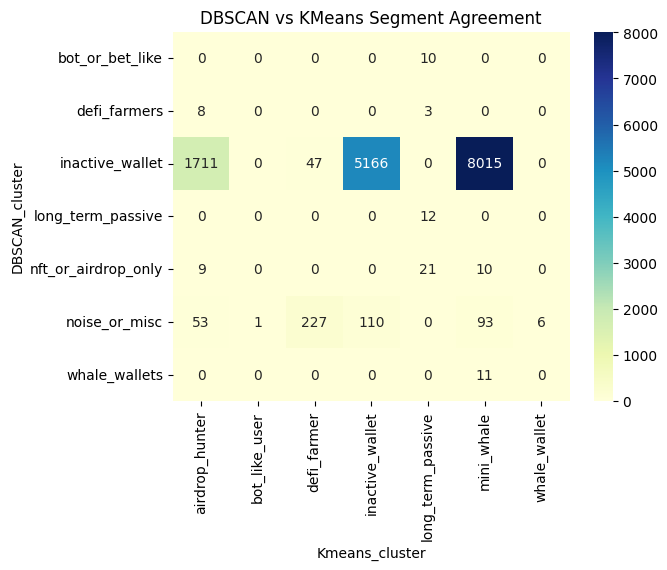

In [121]:
import seaborn as sns
import pandas as pd

confusion_matrix = pd.crosstab(df_transformed['DBSCAN_cluster'], df_transformed['Kmeans_cluster'])
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("DBSCAN vs KMeans Segment Agreement")
plt.show()

In [123]:
df_transformed.head(1)

,FROM_ADDRESS,unique_function_count,total_tx_count,avg_value_sent,total_value_sent,GAS_USED,gas_efficiency,active_days,contract_diversity,avg_tx_per_day,first_last_tx_diff,cluster,cluster_HDBSCAN,cluster_kmeans,cluster_DBSCAN,DBSCAN_cluster,HDBSCAN_cluster,Kmeans_cluster,segment_agreement_count,final_user_segment
0,0x0000000000000068f116a894984e2db1123eb395,4,4.143135,0.0,0.0,10.222803,0.12,60,1.791759,1.03,14.0,1,1,1,1,inactive_wallet,long_term_passive,airdrop_hunter,0,long_term_passive


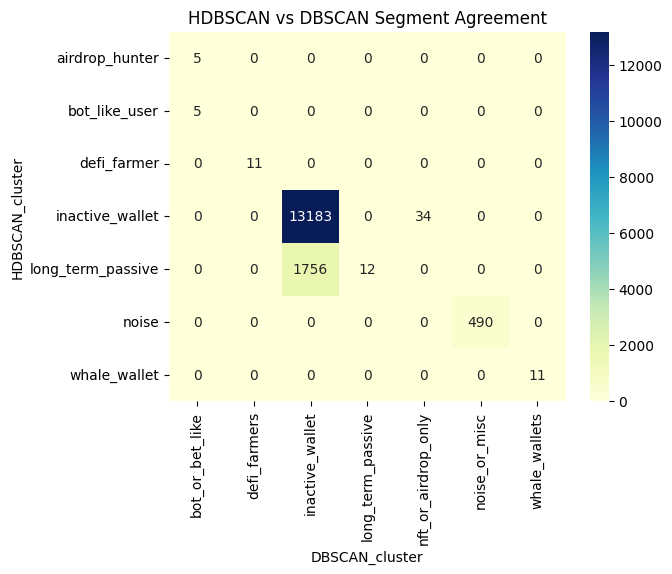

In [125]:
confusion_matrix = pd.crosstab(df_transformed['HDBSCAN_cluster'], df_transformed['DBSCAN_cluster'])
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("HDBSCAN vs DBSCAN Segment Agreement")
plt.show()

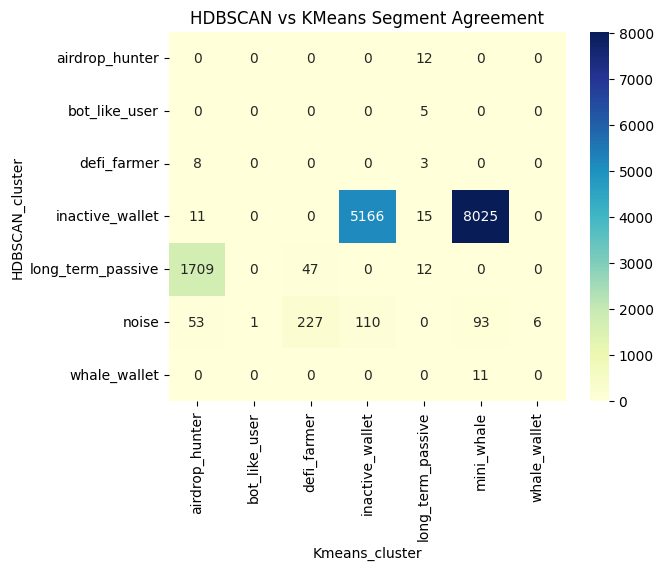

In [124]:
confusion_matrix = pd.crosstab(df_transformed['HDBSCAN_cluster'], df_transformed['Kmeans_cluster'])
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("HDBSCAN vs KMeans Segment Agreement")
plt.show()

In [122]:
df_transformed.groupby('final_user_segment').mean(numeric_only=True)

,unique_function_count,total_tx_count,avg_value_sent,total_value_sent,GAS_USED,gas_efficiency,active_days,contract_diversity,avg_tx_per_day,first_last_tx_diff,cluster,cluster_HDBSCAN,cluster_kmeans,cluster_DBSCAN,segment_agreement_count
final_user_segment,,,,,,,,,,,,,,,
airdrop_hunter,2.200000,2.815291,0.069436,1.723198,9.601761,0.132462,33.015385,1.198899,1.184923,12.353846,1.476923,1.476923,1.369231,1.476923,0.000000
bot_like_user,4.666667,2.253259,0.000000,0.000000,10.103327,0.071667,6.166667,1.629654,4.500000,0.000000,5.666667,5.666667,3.166667,5.666667,0.000000
defi_farmer,7.495798,3.899289,0.094037,19.986758,10.159150,0.143782,106.668067,2.686761,1.032185,12.752101,-0.647059,-0.647059,1.978992,-0.647059,0.000000
inactive_wallet,1.116895,0.802666,0.028498,0.049024,10.234805,0.431761,1.532420,0.730015,1.001792,0.000000,0.014073,0.014073,3.040100,0.014073,1.779148
long_term_passive,2.470588,1.881327,0.001737,0.015564,9.470975,0.142636,8.388009,1.155315,1.001533,13.701357,1.057127,1.057127,1.040158,1.057127,0.020362
mini_whale,1.559140,1.109709,1.623372,37.423342,11.691719,0.559677,2.387097,0.838703,1.062473,3.483871,-1.000000,-1.000000,5.000000,-1.000000,0.000000
noise_or_misc,2.409091,2.069533,0.116569,0.685045,9.121857,0.071364,13.054545,1.044027,1.436455,1.254545,-1.000000,-1.000000,0.000000,-1.000000,0.000000
whale_wallet,3.941176,3.351131,2.266309,58.586242,10.334560,0.415882,1036.058824,2.501396,1.144706,4.941176,1.588235,1.588235,5.352941,1.588235,0.000000


In [126]:
def decide_final_segment(row):
    dbscan = row['DBSCAN_cluster']
    hdbscan = row['HDBSCAN_cluster']
    kmeans = row['Kmeans_cluster']

    # اگر هر سه یکی بودن
    if dbscan == hdbscan == kmeans:
        return dbscan

    # اگر HDBSCAN با بقیه فرق داره ولی برچسب noise نیست
    if hdbscan != 'noise' and hdbscan != 'noise_or_misc':
        return hdbscan

    # اگر HDBSCAN برچسب noise داده ولی KMeans چیز معناداری گفته
    if hdbscan in ['noise', 'noise_or_misc'] and kmeans != 'inactive_wallet':
        return kmeans

    # در نهایت، fallback روی DBSCAN
    return dbscan

# اعمال تابع به دیتافریم
df_transformed['final_user_segment'] = df_transformed.apply(decide_final_segment, axis=1)

In [127]:
df_transformed['final_user_segment'].value_counts()

inactive_wallet      13217
long_term_passive     1768
defi_farmer            238
noise_or_misc          110
mini_whale              93
airdrop_hunter          65
whale_wallet            17
bot_like_user            6
Name: final_user_segment, dtype: int64

In [134]:
round((13217/15514)*100)

85

In [131]:
df_transformed['final_user_segment'].count()

15514

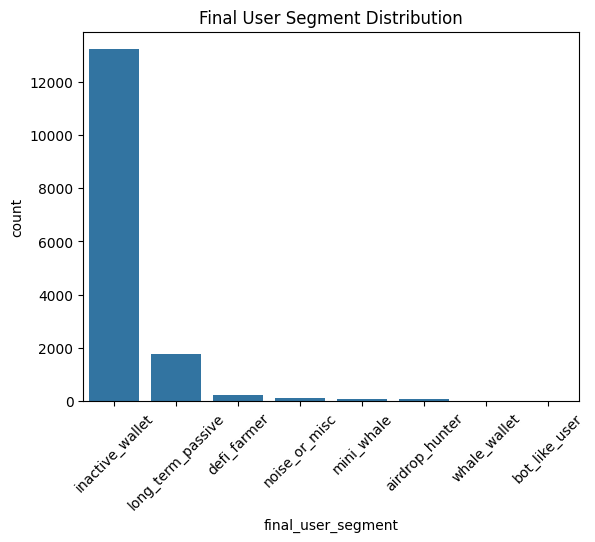

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df_transformed, x='final_user_segment', order=df_transformed['final_user_segment'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Final User Segment Distribution")
plt.show()